In [54]:
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from datetime import date
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pickle
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score, fbeta_score
from sklearn.preprocessing import scale, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

import optuna

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', None)

In [55]:
def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return accuracy_score(y_true, y_pred)

def precision(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    return precision_score(y_true, y_pred)

def recall(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    return recall_score(y_true, y_pred)

def get_metrics(y_train: np.ndarray,
                y_train_pred: np.ndarray,
            
                y_test: np.ndarray,
                y_pred: np.ndarray,
                name: str,
                scaler: str,
                model,
                x: np.ndarray,
                y: np.ndarray,
                ):
    """Генерация таблицы с метриками"""
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]
    df_metrics['scaler'] = [scaler]

    df_metrics['train_accuracy'] = accuracy_score(y_train, y_train_pred)
    df_metrics['test_accuracy'] = accuracy_score(y_test, y_pred)

    df_metrics['recall'] = recall_score(y_test, y_pred)
    df_metrics['precision'] = precision_score(y_test, y_pred)

    df_metrics['F1'] = f1_score(y_test, y_pred)

    df_metrics['cv_roc_auc'] = cross_val_score(model, x, y, cv=5, scoring='roc_auc').mean()
    df_metrics['pr_auc'] = cross_val_score(model, x, y, cv=5, scoring='average_precision').mean()

    return df_metrics

In [56]:
df = pd.read_csv('data/input/dataset.csv')
users = df['user_id']
df = df.drop(columns={ 'user_id'})

In [57]:
# fill na
# df['trade_time'] = df['trade_time'].fillna(df['trade_time'].median())
# df['first_dep'] = df['first_dep'].fillna(df['first_dep'].median())
# df['first_withd'] = df['first_withd'].fillna(df['first_withd'].median())
# df['withd_cond'] = df['withd_cond'].fillna(df['withd_cond'].median())
# df['withdrawal'] = df['withdrawal'].fillna(df['withd_cond'].median())

# df['deposit'] = df['deposit'].fillna(df['deposit'].median())

In [58]:
df.isna().sum()

pnl               0
vol_sum           0
vol_mean          0
vol_median        0
trades_qty        0
account_qty       0
trade_time        0
deposit           0
withdrawal        0
first_dep         0
dif_dep_with      0
diff_reg_trade    0
btc_price         0
full_pnl          0
full_volume       0
reg_year          0
reg_month_sin     0
reg_month_cos     0
reg_day_sin       0
reg_day_cos       0
dtype: int64

In [59]:
# coding target
df.loc[df['full_pnl']>=0, 'full_pnl'] = 0
df.loc[df['full_pnl']<0, 'full_pnl'] = 1

<Axes: >

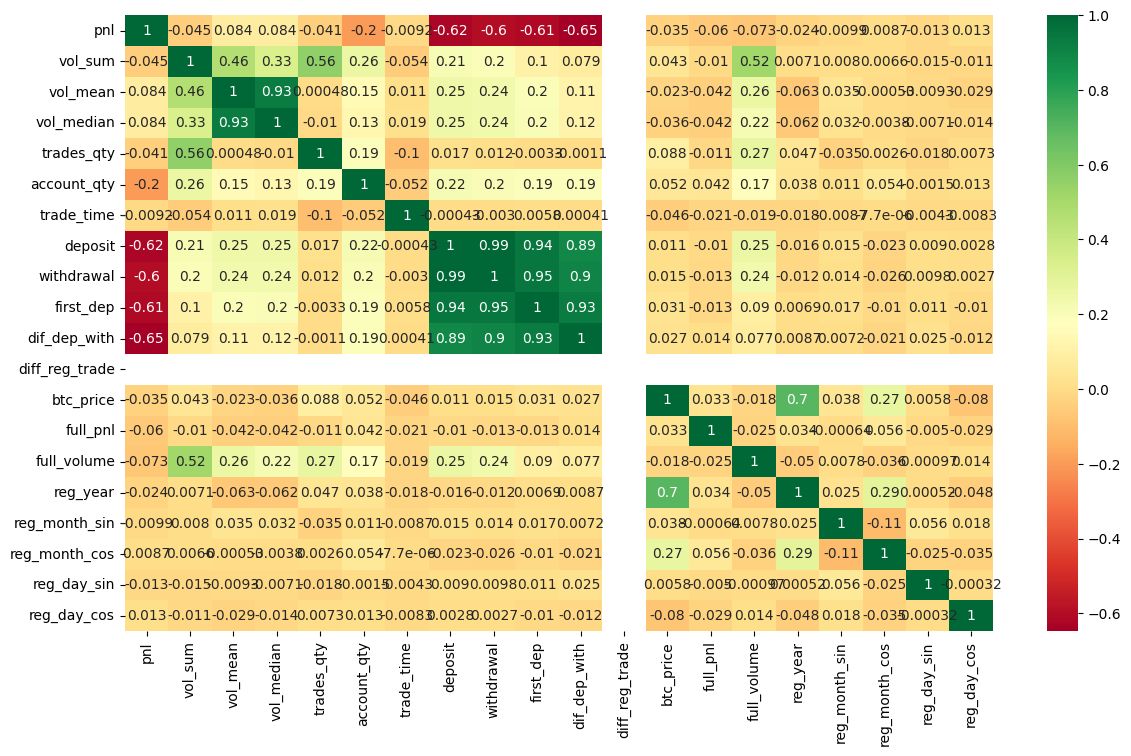

In [60]:
plt.figure(figsize=(14,8))
sns.heatmap(data=df.corr(),  annot=True, cmap='RdYlGn')

In [61]:
# del collinearity features
# df = df.drop(columns={'withdrawal', 'first_dep', 'first_withd', 'dif_dep_with', 'lev_sum', 'vol_mean'})
# try save lev_sum

In [62]:
df.columns

Index(['pnl', 'vol_sum', 'vol_mean', 'vol_median', 'trades_qty', 'account_qty',
       'trade_time', 'deposit', 'withdrawal', 'first_dep', 'dif_dep_with',
       'diff_reg_trade', 'btc_price', 'full_pnl', 'full_volume', 'reg_year',
       'reg_month_sin', 'reg_month_cos', 'reg_day_sin', 'reg_day_cos'],
      dtype='object')

In [63]:
len(df[df['full_pnl']==0])/ (len(df[df['full_pnl']==1]) + len(df[df['full_pnl']==0]))

0.17586206896551723

upsampling

In [64]:
# samp = df[df['full_pnl']==0].sample(200)
# df = pd.concat([df, samp])

In [65]:
df.tail()

,pnl,vol_sum,vol_mean,vol_median,trades_qty,account_qty,trade_time,deposit,withdrawal,first_dep,dif_dep_with,diff_reg_trade,btc_price,full_pnl,full_volume,reg_year,reg_month_sin,reg_month_cos,reg_day_sin,reg_day_cos
3185,-13.83,"1,179.17",589.59,589.59,2,1,0.95,288.28,53.87,91.51,0.00,1,"10,763.23",1.00,"1,179.17",2019,-0.87,-0.50,-0.79,-0.61
3186,-461.95,"15,460.65","7,730.33","7,730.33",2,1,41.53,"1,293.15","2,202.53","1,293.15",754.31,1,"4,879.88",1.00,"15,460.65",2019,0.87,-0.50,0.39,0.92
3187,3.03,"6,587.77","3,293.88","3,293.88",2,1,0.08,156.58,0.00,156.58,0.00,1,"4,879.88",1.00,"30,979.90",2019,0.87,-0.50,0.39,0.92
3188,-34.70,592.84,148.21,139.54,4,1,157.35,143.71,124.87,7.12,-0.62,1,"6,845.04",1.00,592.84,2020,0.87,-0.50,0.49,-0.87
3189,-81.48,"53,163.22","1,208.26","1,259.98",44,1,1.93,302.85,191.50,2.85,-188.65,1,"7,257.67",1.00,"72,829.10",2020,0.87,-0.50,-0.49,-0.87


In [66]:
random=42
x = df.drop(columns={'full_pnl'}) #  'user_id'
y = np.array(df['full_pnl']).reshape((-1, 1))


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=random)


# Подбор модели

In [ ]:
p1 = Pipeline([
    ('StandardScaler', StandardScaler()),
    ('LogisticRegression', LogisticRegression(random_state=random))
]).fit(x_train, y_train)

p2 = Pipeline([
    ('MinMaxScaler', MinMaxScaler()),
    ('LogisticRegression', LogisticRegression(random_state=random))
]).fit(x_train, y_train)

p3 = Pipeline([
    ('StandardScaler', StandardScaler()),
    ('RidgeClassifier', RidgeClassifier(random_state=random))
]).fit(x_train, y_train)

p4 = Pipeline([
    ('MinMaxScaler', MinMaxScaler()),
    ('RidgeClassifier', RidgeClassifier(random_state=random))
]).fit(x_train, y_train)

p5 = Pipeline([
    ('StandardScaler', StandardScaler()),
    ('XGBClassifier', XGBClassifier(random_state=random))
]).fit(x_train, y_train)

p6 = Pipeline([
    ('MinMaxScaler', MinMaxScaler()),
    ('XGBClassifier', XGBClassifier(random_state=random))
]).fit(x_train, y_train)

p7 = Pipeline([
    ('StandardScaler', StandardScaler()),
    ('LGBMClassifier', LGBMClassifier(random_state=random))
]).fit(x_train, y_train)

p8 = Pipeline([
    ('MinMaxScaler', MinMaxScaler()),
    ('LGBMClassifier', LGBMClassifier(random_state=random))
]).fit(x_train, y_train)

p9 = Pipeline([
    ('StandardScaler', StandardScaler()),
    ('RandomForestClassifier', RandomForestClassifier(random_state=random))
]).fit(x_train, y_train)

p10 = Pipeline([
    ('MinMaxScaler', MinMaxScaler()),
    ('RandomForestClassifier', RandomForestClassifier(random_state=random))
]).fit(x_train, y_train)

In [ ]:
metrics_df = pd.DataFrame()
for p in [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10]:
    metrics_df = pd.concat([metrics_df, get_metrics(y_train, p.predict(x_train), y_test, p.predict(x_test), list(p.named_steps.keys())[1], list(p.named_steps.keys())[0], p, x, y)])

In [71]:
metrics_df

,model,scaler,train_accuracy,test_accuracy,recall,precision,F1,cv_roc_auc,pr_auc
0,LogisticRegression,StandardScaler,0.82,0.84,0.99,0.84,0.91,0.56,0.85
0,LogisticRegression,MinMaxScaler,0.82,0.84,1.00,0.84,0.91,0.54,0.84
0,RidgeClassifier,StandardScaler,0.82,0.84,0.99,0.84,0.91,0.55,0.85
0,RidgeClassifier,MinMaxScaler,0.82,0.84,1.00,0.84,0.91,0.54,0.85
0,XGBClassifier,StandardScaler,1.00,0.87,0.93,0.92,0.93,0.86,0.96
0,XGBClassifier,MinMaxScaler,1.00,0.87,0.93,0.92,0.93,0.86,0.96
0,LGBMClassifier,StandardScaler,1.00,0.89,0.94,0.93,0.93,0.87,0.96
0,LGBMClassifier,MinMaxScaler,1.00,0.89,0.94,0.93,0.93,0.86,0.96
0,RandomForestClassifier,StandardScaler,1.00,0.88,0.95,0.91,0.93,0.86,0.96
0,RandomForestClassifier,MinMaxScaler,1.00,0.88,0.95,0.91,0.93,0.86,0.96


In [ ]:
scaler = StandardScaler()
x_train_proc = scaler.fit_transform(x_train)
x_test_proc = scaler.fit_transform(x_test)

In [ ]:
xgb = XGBClassifier().fit(x_train_proc, y_train)
metrics_df =  get_metrics(y_train, xgb.predict(x_train_proc),
                           y_test, xgb.predict(x_test_proc),
                             'xgb', xgb,
                              x, y)
metrics_df

,model,train_accuracy,test_accuracy,recall,precision,F1,cv_roc_auc,pr_auc
0,xgb,1.00,0.84,0.99,0.85,0.91,0.86,0.96


In [ ]:
xgb.predict_proba(X=x_train_proc)

array([[0.00200337, 0.9979966 ],
       [0.01242131, 0.9875787 ],
       [0.98592186, 0.01407813],
       ...,
       [0.00393742, 0.9960626 ],
       [0.93917316, 0.06082684],
       [0.01093096, 0.98906904]], dtype=float32)

# XGBClassifier

In [ ]:
def objective(trial):
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart', 'gbtree', 'dart']),
        'learning_rate': trial.suggest_float('learning_rate', 0, 1),
        'max_depth': trial.suggest_int('max_depth', 4, 24),
        'min_split_loss': trial.suggest_int('min_split_loss', 0, 100),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10),
        'subsample': trial.suggest_float('subsample', 0.05, 1),
        'verbosity': 1,
        'n_jobs': 3
    }

    # xgb = XGBClassifier(**params).fit(x_test_proc, y_train) 
    # y_pred = xgb.predict(x_test_proc)
    # score = fbeta_score(y_true=y_test, y_pred=y_pred, beta=0.21)

    xgb = XGBClassifier(**params).fit(x_train_proc, y_train) 
    score = cross_val_score(X=x_train_proc, y=y_train, scoring='f1_macro', cv=3, estimator=xgb).mean()
    return score

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective, n_trials=10)


In [ ]:
xgb = XGBClassifier(**study_xgb.best_params).fit(x_train_proc, y_train)

# set threashold
print(xgb.classes_)
xgb_predict = np.array(xgb.predict_proba(x_test_proc))[:, 1]#.reshape(-1,1)
xgb_predict = xgb_predict > 0.75
xgb_predict = xgb_predict.astype(int)

metrics_df =  get_metrics(y_train, xgb.predict(x_train_proc), y_test, xgb_predict, 'xgb', xgb, x, y)

with open ('saved_models/XGBClassifier_1.pickle', 'wb') as file:
    pickle.dump(xgb, file)
metrics_df

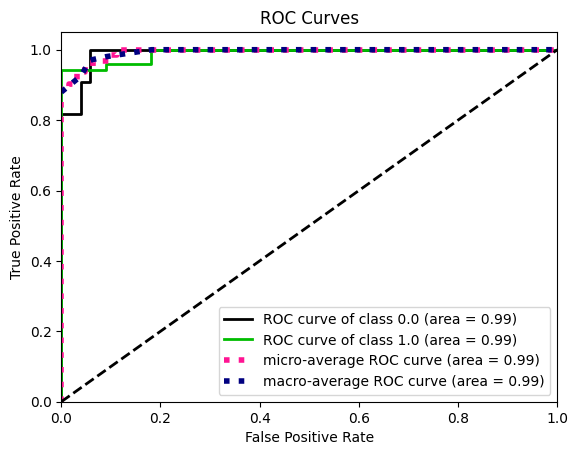

In [ ]:
import scikitplot as skplt
import matplotlib.pyplot as plt

y_probas = xgb.predict_proba(x_train_proc)
skplt.metrics.plot_roc_curve(y_train, y_probas)
plt.show()

In [ ]:
# feature importance
feature_importance = xgb.get_booster().get_fscore()
print(feature_importance)
print(x.columns)
feature_importance = [feature_importance[f'f{i}'] for i in range(len(feature_importance))]
feature_importance = pd.DataFrame({
    'feature': x.columns,
    'value': feature_importance
})
feature_importance.sort_values('value')


{'f0': -46.24138259887695, 'f1': 3.6889843940734863, 'f2': -0.1709659993648529, 'f3': 0.3415969908237457, 'f4': 1.2525651454925537, 'f5': -4.548699855804443, 'f6': 0.6692072153091431, 'f7': -0.778974711894989, 'f8': 1.2491679191589355, 'f9': 1.9171873331069946, 'f10': 1.4800108671188354, 'f11': 0.5181015729904175, 'f12': 0.0, 'f13': 0.012998166494071484, 'f14': 0.0, 'f15': -0.7659037709236145, 'f16': -0.2472122609615326, 'f17': 0.07006915658712387, 'f18': 0.016968421638011932}
Index(['pnl', 'vol_sum', 'vol_mean', 'vol_median', 'trades_qty', 'account_qty',
       'trade_time', 'deposit', 'first_dep', 'withdrawal', 'first_withd',
       'dif_dep_with', 'diff_reg_trade', 'btc_price', 'reg_year',
       'reg_month_sin', 'reg_month_cos', 'reg_day_sin', 'reg_day_cos'],
      dtype='object')


,feature,value
0,pnl,-46.24
5,account_qty,-4.55
7,deposit,-0.78
15,reg_month_sin,-0.77
16,reg_month_cos,-0.25
2,vol_mean,-0.17
14,reg_year,0.00
12,diff_reg_trade,0.00
13,btc_price,0.01
18,reg_day_cos,0.02


# DBSCAN


In [ ]:
from sklearn.cluster import DBSCAN
from numpy import unique
from collections import Counter
from sklearn.feature_selection import RFE


df = pd.read_csv('/Users/p.matchenkov/NotebookProjects/aurora/b_book_select/ML_selection/data/input/first_two_weeks_dataset.csv')
users = df['user_id']
df = df#.drop(columns={'user_created_date_time', 'user_id'})
df.tail(1)

In [ ]:
x = df.drop(columns={'pnl', 'user_id', 'full_pnl'})
y = np.array(df['full_pnl']).reshape((-1, 1))

scaler = StandardScaler()
x = scaler.fit_transform(x)

RFE

In [ ]:
pnl = dict()

for eps in np.arange(0.05, 10, 0.05):
    dbscan_model = DBSCAN(eps=eps, min_samples=50).fit(x, y)
    labels = dbscan_model.labels_

    df['cluster'] = dbscan_model.labels_
    result = df.groupby('cluster').agg({'full_pnl': [sum, 'count']}).reset_index()
    pnl[eps] = df.loc[df['cluster']!= -1, 'full_pnl'].sum()

In [ ]:
best_eps = min(pnl, key=pnl.get)
dbscan_model = DBSCAN(eps=best_eps, min_samples=50).fit(x, y)

df['cluster'] = dbscan_model.labels_
result = df.groupby('cluster').agg({'full_pnl': [sum, 'count']}).reset_index()
result

In [ ]:
df.loc[df['cluster']== -1]

GaussianMixture

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.mixture import GaussianMixture

gaussian_model = GaussianMixture(n_components=2, random_state=42)

# train the model
gaussian_model.fit(x, y)

gaussian_result = gaussian_model.predict(x)
unique(gaussian_result)

array([0, 1])

In [ ]:
df['cluster'] = gaussian_result
df.groupby('cluster').agg({'full_pnl': sum, 'user_id': pd.Series.nunique})